In [ ]:
from google.colab import files
uploaded = files.upload()


Saving facebook_combined.txt to facebook_combined.txt


In [ ]:
import numpy as np
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt

from networkx.algorithms.community import greedy_modularity_communities
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report

)

np.random.seed(42)
random.seed(42)

G = nx.read_edgelist("facebook_combined.txt")
G = G.to_undirected()
print("Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())


Nodes: 4039 Edges: 88234


In [ ]:

def extract_features(G):
    degree = dict(G.degree())
    clustering = nx.clustering(G)
    betweenness = nx.betweenness_centrality(G, k=min(500, G.number_of_nodes()))
    pagerank = nx.pagerank(G)
    comms = list(greedy_modularity_communities(G))

    node2comm = {}
    for cid, comm in enumerate(comms):
        for node in comm:
            node2comm[node] = cid

    nodes = list(G.nodes())
    df = pd.DataFrame({
        "node": nodes,
        "degree": [degree[n] for n in nodes],
        "clustering": [clustering[n] for n in nodes],
        "betweenness": [betweenness[n] for n in nodes],
        "pagerank": [pagerank[n] for n in nodes],
        "community": [node2comm.get(n, -1) for n in nodes]
    })

    return df

df_base = extract_features(G)
df_base.head()


,node,degree,clustering,betweenness,pagerank,community
0,0,347,0.041962,1.467630e-01,0.006290,4
1,1,17,0.419118,1.629880e-06,0.000236,4
2,2,10,0.888889,0.000000e+00,0.000203,4
3,3,17,0.632353,5.814274e-07,0.000226,4
4,4,10,0.866667,1.238543e-07,0.000238,4


In [ ]:
bot_ratio = 0.15
num_nodes = len(df_base)
num_bots = int(bot_ratio * num_nodes)

df_base["bot_score"] = (
    df_base["degree"].rank(method="first", ascending=True) +
    df_base["clustering"].rank(method="first", ascending=True) +
    df_base["pagerank"].rank(method="first", ascending=True)
)

df_sorted = df_base.sort_values("bot_score", ascending=True)
bot_nodes = set(df_sorted["node"].head(num_bots).values)

df_base["label"] = df_base["node"].apply(lambda x: 1 if x in bot_nodes else 0)
print(df_base["label"].value_counts())
df_base.head()


label
0    3434
1     605
Name: count, dtype: int64


,node,degree,clustering,betweenness,pagerank,community,bot_score,label
0,0,347,0.041962,1.467630e-01,0.006290,4,8149.0,0
1,1,17,0.419118,1.629880e-06,0.000236,4,4439.0,0
2,2,10,0.888889,0.000000e+00,0.000203,4,6278.0,0
3,3,17,0.632353,5.814274e-07,0.000226,4,5864.0,0
4,4,10,0.866667,1.238543e-07,0.000238,4,6682.0,0


In [ ]:
feature_cols = ["degree", "clustering", "betweenness", "pagerank", "community"]
X_base = df_base[feature_cols].values
y = df_base["label"].values

idx = np.arange(len(df_base))

idx_train, idx_test, y_train, y_test = train_test_split(
    idx, y, test_size=0.3, random_state=42, stratify=y
)

X_train = X_base[idx_train]
X_test = X_base[idx_test]

clf_base = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
clf_base.fit(X_train, y_train)

def print_metrics(name, y_true, y_pred):
    print(format(name))
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_true, y_pred, zero_division=0))
    print("F1-score :", f1_score(y_true, y_pred, zero_division=0))
    print()

y_pred_base = clf_base.predict(X_test)
print_metrics("Baseline", y_test, y_pred_base)
print(classification_report(y_test, y_pred_base, digits=4))


Baseline
Accuracy : 0.9884488448844885
Precision: 0.9941176470588236
Recall   : 0.9285714285714286
F1-score : 0.9602272727272727

              precision    recall  f1-score   support

           0     0.9875    0.9990    0.9932      1030
           1     0.9941    0.9286    0.9602       182

    accuracy                         0.9884      1212
   macro avg     0.9908    0.9638    0.9767      1212
weighted avg     0.9885    0.9884    0.9883      1212



In [ ]:
G_evasion = G.copy()

bot_nodes_set = set(df_base[df_base["label"] == 1]["node"])
human_nodes_set = set(df_base[df_base["label"] == 0]["node"])

deg = dict(G.degree())
avg_deg_humans = np.mean([deg[n] for n in human_nodes_set])

for b in bot_nodes_set:
    neighbors = list(G_evasion.neighbors(b))
    if len(neighbors) > 1:
        k_remove = max(1, int(len(neighbors) * 0.5))
        for t in random.sample(neighbors, k_remove):
            if G_evasion.has_edge(b, t):
                G_evasion.remove_edge(b, t)

    mid_humans = [n for n in human_nodes_set
                  if avg_deg_humans * 0.8 < deg[n] < avg_deg_humans * 1.2]
    if len(mid_humans) >= 3:
        for t in random.sample(mid_humans, 3):
            G_evasion.add_edge(b, t)

print("Evasion graph:", G_evasion.number_of_nodes(), "nodes,", G_evasion.number_of_edges(), "edges")

df_evasion = extract_features(G_evasion)
df_evasion = df_evasion.merge(df_base[["node", "label"]], on="node", how="left")

X_evasion = df_evasion[feature_cols].values
X_test_evasion = X_evasion[idx_test]
y_test_evasion = y[idx_test]

y_pred_evasion = clf_base.predict(X_test_evasion)

print_metrics("After Structural Evasion", y_test_evasion, y_pred_evasion)
print(classification_report(y_test_evasion, y_pred_evasion, digits=4))


Evasion graph: 4039 nodes, 87526 edges
After Structural Evasion
Accuracy : 0.9735973597359736
Precision: 0.8504672897196262
Recall   : 1.0
F1-score : 0.9191919191919192

              precision    recall  f1-score   support

           0     1.0000    0.9689    0.9842      1030
           1     0.8505    1.0000    0.9192       182

    accuracy                         0.9736      1212
   macro avg     0.9252    0.9845    0.9517      1212
weighted avg     0.9775    0.9736    0.9745      1212



In [ ]:
G_poison = G.copy()

nodes_array = df_base["node"].values
bot_mask = (df_base["label"].values == 1)

train_bot_idx = [i for i in idx_train if bot_mask[i]]
train_bot_nodes = nodes_array[train_bot_idx]

deg = dict(G_poison.degree())
humans_only = [n for n in nodes_array if n not in bot_nodes_set]
deg_humans = {n: deg[n] for n in humans_only}
top_humans = sorted(humans_only, key=lambda n: deg_humans[n], reverse=True)

n_poison = min(60, len(train_bot_nodes))
for b in train_bot_nodes[:n_poison]:
    added = 0
    for h in top_humans:
        if not G_poison.has_edge(b, h):
            G_poison.add_edge(b, h)
            added += 1
        if added >= 5:
            break

print("Poison graph:", G_poison.number_of_nodes(), "nodes,", G_poison.number_of_edges(), "edges")

df_poison = extract_features(G_poison)
df_poison = df_poison.merge(df_base[["node", "label"]], on="node", how="left")

X_poison = df_poison[feature_cols].values

X_train_poison = X_poison[idx_train]
y_train_poison = y[idx_train]

clf_poison = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
clf_poison.fit(X_train_poison, y_train_poison)

y_pred_poison = clf_poison.predict(X_test)

print_metrics("After Graph Poisoning", y_test, y_pred_poison)
print(classification_report(y_test, y_pred_poison, digits=4))


Poison graph: 4039 nodes, 88534 edges
After Graph Poisoning
Accuracy : 0.9867986798679867
Precision: 0.9882352941176471
Recall   : 0.9230769230769231
F1-score : 0.9545454545454546

              precision    recall  f1-score   support

           0     0.9866    0.9981    0.9923      1030
           1     0.9882    0.9231    0.9545       182

    accuracy                         0.9868      1212
   macro avg     0.9874    0.9606    0.9734      1212
weighted avg     0.9868    0.9868    0.9866      1212



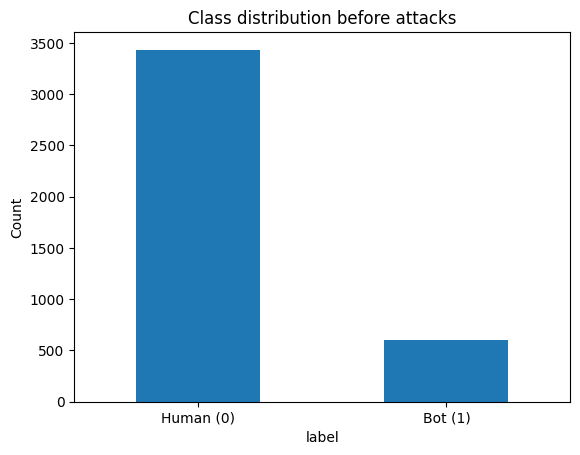

In [ ]:
df_base["label"].value_counts().plot(kind="bar")
plt.xticks([0,1], ["Human (0)", "Bot (1)"], rotation=0)
plt.ylabel("Count")
plt.title("Class distribution before attacks")
plt.show()


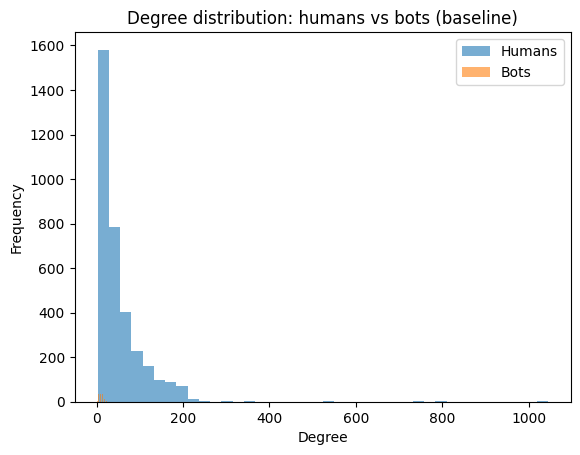

In [ ]:
plt.hist(df_base[df_base["label"]==0]["degree"], bins=40, alpha=0.6, label="Humans")
plt.hist(df_base[df_base["label"]==1]["degree"], bins=40, alpha=0.6, label="Bots")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree distribution: humans vs bots (baseline)")
plt.legend()
plt.show()


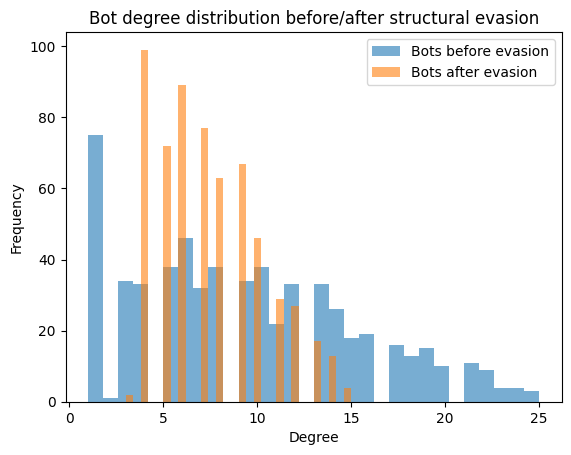

In [ ]:
# degrees before attack
deg_before = df_base[df_base["label"]==1]["degree"]
# degrees after attack
deg_after = df_evasion[df_evasion["label"]==1]["degree"]

plt.hist(deg_before, bins=30, alpha=0.6, label="Bots before evasion")
plt.hist(deg_after, bins=30, alpha=0.6, label="Bots after evasion")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Bot degree distribution before/after structural evasion")
plt.legend()
plt.show()


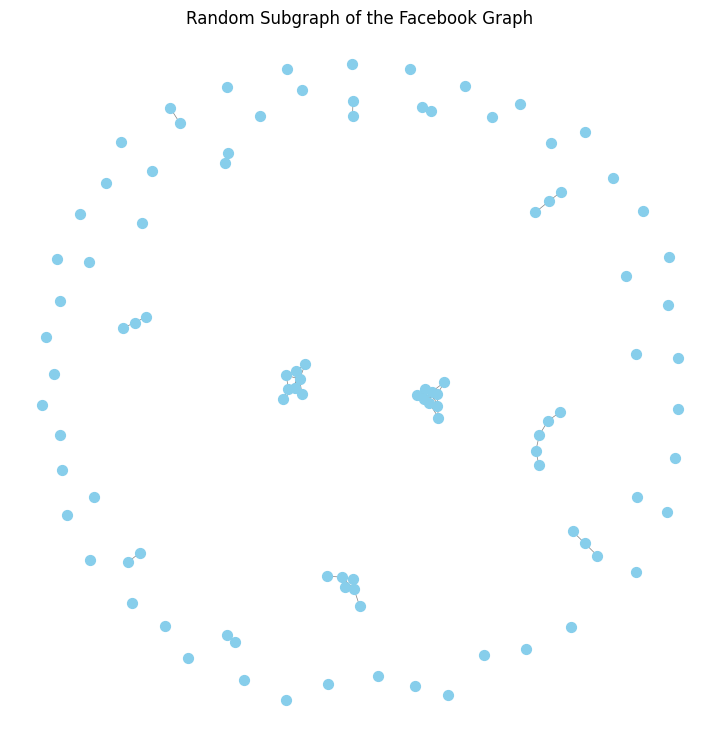

In [ ]:
# === Draw a simple random subgraph ===
import random

# take 100 random nodes to avoid clutter
sample_nodes = random.sample(list(G.nodes()), 100)

# build subgraph
H = G.subgraph(sample_nodes)

# layout for drawing
pos = nx.spring_layout(H, seed=42)

plt.figure(figsize=(7,7))
nx.draw(H, pos,
        node_size=50,
        node_color="skyblue",
        edge_color="gray",
        width=0.5)
plt.title("Random Subgraph of the Facebook Graph")
plt.show()


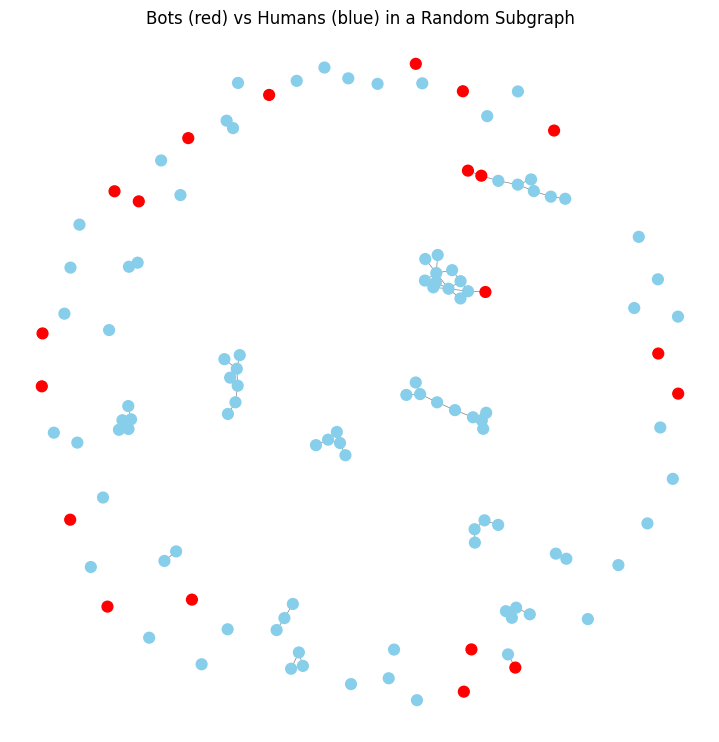

In [ ]:
# === Draw subgraph with bots (red) vs humans (blue) ===

# sample again (you can use a different seed)
sample_nodes = random.sample(list(G.nodes()), 120)
H2 = G.subgraph(sample_nodes)

# get labels from df_base
labels = dict(zip(df_base["node"], df_base["label"]))

# bot = red, human = blue
colors = ["red" if labels[n] == 1 else "skyblue" for n in H2.nodes()]

pos = nx.spring_layout(H2, seed=24)

plt.figure(figsize=(7,7))
nx.draw(H2, pos,
        node_size=60,
        node_color=colors,
        edge_color="gray",
        width=0.5)
plt.title("Bots (red) vs Humans (blue) in a Random Subgraph")
plt.show()
